In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
import ipywidgets as widgets
from IPython.display import display, clear_output


In [56]:
def reset(T1):
    Mz = np.ones(len(T1))
    return Mz
def invert(Mz,eff=1.0):
    Mz = Mz * -eff
    return Mz

def relax(Mz,T1,t):
    Mz = 1 - (1-Mz) * np.exp(-t/T1)
    return Mz

def read(Mz,FA,N,T1,TR1):
    for i in range(N):
        sig = np.sin(FA / 180 * np.pi) * Mz
        Mz = Mz * np.cos(FA / 180 * np.pi);
        Mz = relax(Mz,T1,TR1)
    return Mz,sig


In [170]:
def singleTR(Mz,param):
    try:
        invEff = param['invEff']
    except:
        invEff = 1.0
    # calculate helper times
    readDur = param['N'] * param['TR1']
    TI1fill = param['TI1'] - readDur/2
    TI2fill = param['TI2'] - param['TI1'] - readDur
    TRfill = param['TR0'] - 2*readDur - TI1fill - TI2fill
    if TI1fill < 0:
        raise ValueError("TI1 too short!")
    if TI2fill < 0:
        raise ValueError("TI2 too short!")
    if TRfill < 0:
        raise ValueError("TR too short!")
    N1 = int(param['N']/2)
    N2 = param['N'] - N1
    #plt.plot(param['T1'],Mz,label="fresh")
    Mz = invert(Mz,eff=invEff)
    #plt.plot(param['T1'],Mz,label="invert")
    Mz = relax(Mz,param['T1'],TI1fill)
    # plt.plot(param['T1'],Mz,label="before sig1")
    Mz,sig1 = read(Mz,FA=param['FA1'],N=N1,T1=param['T1'],TR1=param['TR1'])
    Mz = read(Mz,FA=param['FA1'],N=N2,T1=param['T1'],TR1=param['TR1'])[0]
    # plt.plot(param['T1'],Mz,label="after sig1")
    Mz = relax(Mz,param['T1'],TI2fill)
    # plt.plot(param['T1'],Mz,label="before sig2")
    Mz,sig2 = read(Mz,FA=param['FA2'],N=N1,T1=param['T1'],TR1=param['TR1'])
    Mz = read(Mz,FA=param['FA2'],N=N2,T1=param['T1'],TR1=param['TR1'])[0]
    # plt.plot(param['T1'],Mz,label="after sig2")
    Mz = relax(Mz,param['T1'],TRfill)
    # plt.plot(param['T1'],Mz,label="end TR")
    # plt.legend()
    # plt.show()
    return Mz,sig1,sig2

# run enough times to approximate steady state
def runParameters(param):
    Mz = reset(param['T1'])
    niter=7
    for i in range(niter):
        Mz,sig1,sig2 = singleTR(Mz,param)
    return sig1,sig2,Mz


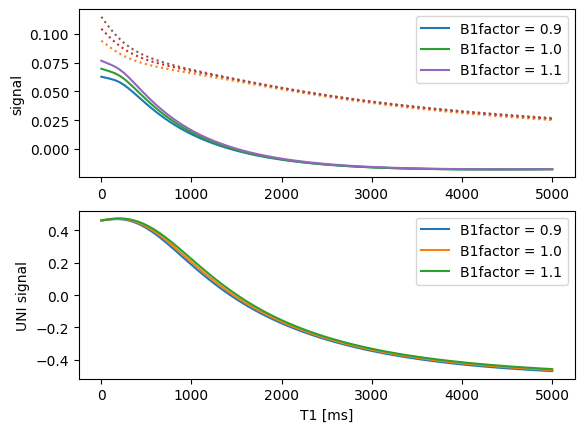

In [231]:
param = dict()
param['TI1'] = 900
param['TI2'] = 4500
param['FA1'] = 4
param['FA2'] = 6
param['TR0'] = 8800
param['TR1'] = 6.5
param['T1'] = np.linspace(1,5000,100)
param['N'] = 224

B1fac = [0.8,0.9,1.0,1.1,1.2]
B1fac = [0.9,1.0,1.1]
# B1fac = [0.8,1.0,1.4,1.6,1.8]

plt.figure()
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
for b1 in B1fac:
    myParam = dict(param)
    myParam['FA1'] = param['FA1'] * b1
    myParam['FA2'] = param['FA2'] * b1
    sig1,sig2,Mz = runParameters(myParam)
    ax1.plot(param['T1'],sig1,label=f'B1factor = {b1}')
    ax1.plot(param['T1'],sig2,':')
    uni = (sig1 * sig2) / (abs(sig1)**2 + abs(sig2)**2)
    ax2.plot(param['T1'],uni,label=f'B1factor = {b1}')
# plt.subplot(2,1,1)
ax1.set_ylabel("signal")
ax1.legend()

# plt.subplot(2,1,2)
ax2.set_xlabel("T1 [ms]")
ax2.set_ylabel("UNI signal")
ax2.legend()
plt.show()

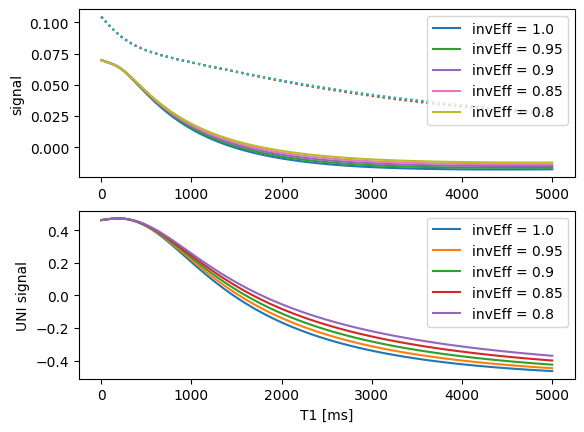

In [227]:
invEff = [1.0,0.95,0.9,0.85,0.8]
plt.figure()
for eff in invEff:
    myParam = dict(param)
    myParam['invEff'] = eff
    sig1,sig2,Mz = runParameters(myParam)
    plt.subplot(2,1,1)
    plt.plot(param['T1'],sig1,label=f'invEff = {eff}')
    plt.plot(param['T1'],sig2,':')
    uni = (sig1 * sig2) / (abs(sig1)**2 + abs(sig2)**2)
    plt.subplot(2,1,2)
    plt.plot(param['T1'],uni,label=f'invEff = {eff}')
plt.subplot(2,1,1)
plt.ylabel("signal")
plt.legend()

plt.subplot(2,1,2)
plt.xlabel("T1 [ms]")
plt.ylabel("UNI signal")
plt.legend()
plt.show()